# Data Collection for Maps Project
### by Sam Xifaras

This notebook shows how I collected data from the sources I used and the code used to generate the CSV's.

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

from sklearn.linear_model import LinearRegression

from bs4 import BeautifulSoup

## Section 1
### Collecting Data from tradingeconomics.com
Although there is a cost to use tradingeconomics's API, I managed to find out how to get indicators for all the countries using some post data fields I got from the Google Chrome developer tools.

In [2]:
postdata = {"ctl00$AjaxScriptManager1$ScriptManager1":"ctl00$ContentPlaceHolder1$defaultUC1$CurrencyMatrixAllCountries1$UpdatePanel1|ctl00$ContentPlaceHolder1$defaultUC1$CurrencyMatrixAllCountries1$LinkButton1",
"__EVENTTARGET":"ctl00$ContentPlaceHolder1$defaultUC1$CurrencyMatrixAllCountries1$LinkButton1",
"__EVENTARGUMENT":"",
"_LASTFOCUS":""}

# Set this to True to obtain the extended list of countries, or False for just the ones that appear on the homepage
extended=True

if extended:
    resp = requests.post("https://tradingeconomics.com", data=postdata)
else:
    resp = requests.get("https://tradingeconomics.com")

In [3]:
soup = BeautifulSoup(resp.text, 'lxml')

table = soup.find(id='ctl00_ContentPlaceHolder1_defaultUC1_CurrencyMatrixAllCountries1_GridView1')

In [4]:
rows = table.find_all('tr')
colnames = [x.text for x in rows[0].find_all('a')]
colnames.insert(0, 'Country')

In [5]:
colnames

['Country',
 'GDP',
 'GDP YoY',
 'GDP QoQ',
 'Interest rate',
 'Inflation rate',
 'Jobless rate',
 'Gov. Budget',
 'Debt/GDP',
 'Current Account',
 'Currency',
 'Population']

In [6]:
df = pd.DataFrame(columns=colnames)
df.shape

(0, 12)

In [7]:
for row in rows[1:]:
    df.loc[df.shape[0]] = [x.text.strip().replace('%', '') for x in row.find_all('a')]

In [8]:
# This makes sure all the data values are numeric except Country
df[[x for x in df.columns if x != 'Country']] = df[[x for x in df.columns if x != 'Country']].apply(pd.to_numeric)

In [9]:
df.head()

,Country,GDP,GDP YoY,GDP QoQ,Interest rate,Inflation rate,Jobless rate,Gov. Budget,Debt/GDP,Current Account,Currency,Population
0,United States,18569,2.3,3.0,1.25,2.2,4.20,-3.5,106.1,-2.6,119.89,324.30
1,Euro Area,11886,2.3,0.6,0.00,1.5,9.10,-1.5,89.2,3.3,1.16,341.01
2,China,11199,6.8,1.7,4.35,1.6,3.95,-3.8,46.2,1.8,6.65,1378.67
3,Japan,4939,1.4,0.6,-0.10,0.7,2.80,-4.5,250.4,3.7,113.11,126.86
4,Germany,3467,2.1,0.6,0.00,1.6,3.60,0.8,68.3,8.3,1.16,82.80


In [10]:
df['GDP per capita'] = (df['GDP'].astype(float) * 1000) / df['Population'].astype(float)
df['log GDP per capita'] = np.log(df['GDP per capita'])

In [11]:
# cols_to_keep contains the selected columns to save to the csv
cols_to_keep = ['Country', 'log GDP per capita']
df[cols_to_keep].to_csv("country_indicators.csv")

## Section 2
### World Happiness Report Data
I didn't make too many changes to the dataset here, except cleaning up the names of the columns and doing a little data analysis.

In [12]:
# Load happiness data
df2 = pd.read_csv("world-happiness-report/2017.csv")
df2.head()

,Country,Happiness.Rank,Happiness.Score,Whisker.high,Whisker.low,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual
0,Norway,1,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,Iceland,3,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,Switzerland,4,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,Finland,5,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182


In [13]:
import re
%matplotlib inline

columns_tmp = df2.columns
columns_tmp = [re.sub(r'\.|_', ' ', x) for x in columns_tmp]
df2.columns = columns_tmp

In [14]:
countries = [x for x in df['Country'].unique() if x in df2['Country'].unique()]

Here, I'm trying to find a correlation between the GDP per capita of the TradingEconomics and the happiness database. In the World Happiness Report, the Economy/GDP per capita column says that the natural log of GDP fits the data much better than regular GDP, so I decided to test it out.

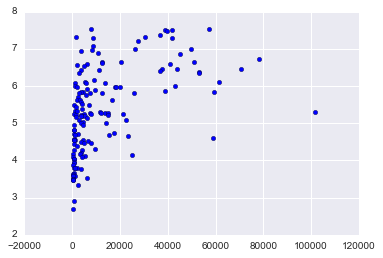

In [15]:
criterion = df['Country'].map(lambda x: x in countries)
criterion2 = df2['Country'].map(lambda x: x in countries)

plt.scatter(df[criterion]['GDP per capita'], df2[criterion2]['Happiness Score'])
plt.show()

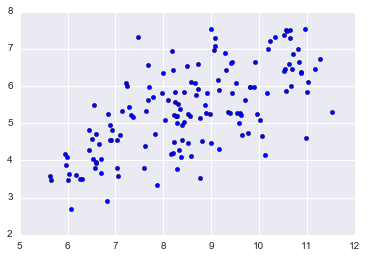

In [16]:
plt.scatter(np.log(df[criterion]['GDP per capita']), df2[criterion2]['Happiness Score'])
plt.show()

It does appear that the log of GDP per capita correlates more linearly with happiness score.

In [17]:
linreg = LinearRegression()
linreg.fit(np.log(df[criterion]['GDP per capita'].reshape(-1, 1)), df2[criterion2]['Happiness Score'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

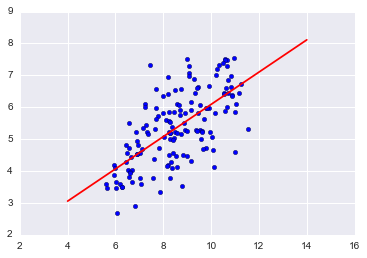

In [18]:
regfunc = lambda x: linreg.coef_[0] * x + linreg.intercept_
regfuncv = np.vectorize(regfunc)
xs = np.arange(4, 15, 1)
ys = regfuncv(xs)

plt.scatter(np.log(df[criterion]['GDP per capita']), df2[criterion2]['Happiness Score'])
plt.plot(xs, ys, color='red')
#lt.axis([-1000, 6000, 0, 2])
plt.show()

In [19]:
linreg.score(np.log(df[criterion]['GDP per capita'].reshape(-1, 1)), df2[criterion2]['Happiness Score'])

0.43535700261597698

Here, I actually clean up the column names and write the data to a new csv.

In [20]:
df3 = pd.read_csv("world-happiness-report/2017.csv")
columns_tmp = df3.columns
columns_tmp = [re.sub(r'\.|_', ' ', x) for x in columns_tmp]
df3.columns = columns_tmp

df3.head()

,Country,Happiness Rank,Happiness Score,Whisker high,Whisker low,Economy GDP per Capita,Family,Health Life Expectancy,Freedom,Generosity,Trust Government Corruption,Dystopia Residual
0,Norway,1,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,Iceland,3,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,Switzerland,4,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,Finland,5,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182


In [21]:
# Add some extra fields that are used in the visualization
df3['Social Support over Happiness'] = df3['Family'] / df3['Happiness Score']
df3['Economy over Happiness'] = df3['Economy  GDP per Capita '] / df3['Happiness Score']

In [22]:
cols_to_keep = ['Country', 'Happiness Score', 'Social Support over Happiness', 'Economy over Happiness']
df3[cols_to_keep].to_csv("world-happiness.csv")